In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('datasets/weatherAUS.csv', index_col=0)

# Columnas

* **Sunshine:** Numero de horas de sol en el dia
* **Rainfall:** Cantidad de lluvia en el dia en mm
* **Evaporation:** La denominada evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
* **WindGustDir:** La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche
* **WindGustSpeed:** La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas previas a la medianoche
* **WindDir9am:** Dirección del viento a las 9 a.m.
* **WindDir3pm:** direccion del viento alas 3pm
* **WindSpeed9am:** Velocidad del viento (km/h) promediada durante 10 minutos antes de las 9 a.m.
* **WindSpeed3pm:** Velocidad del viento (km/h) promediada durante 10 minutos antes de las 3 p.m.
* **Humidity9am:** Humedad (porcentaje) a las 15:00 horas
* **Humidity3pm:**
* **Pressure9am:** La presión atmosférica (hpa) se redujo al nivel medio del mar a las 9 a. m.
* **Pressure3pm:**
* **Cloud9am:** Fracción del cielo oscurecida por las nubes a las 9:00 horas. Esto se mide en "oktas", que son una unidad de octavos. Registra cuántas octavas partes del cielo están oscurecidas por las nubes. Una medida 0 indica cielo completamente despejado mientras que un 8 indica que está completamente nublado.
* **Cloud3pm:**
* **Temp9am:** Temperatura (grados C) a las 9 a.m.
* **Temp3pm:**
* **RainToday:** Booleano: 1 si la precipitación (mm) en las 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
* **RainTomorrow:** La cantidad de lluvia del día siguiente en mm. Se utiliza para crear la variable de respuesta RainTomorrow. Una especie de medida del "riesgo".
* **RainfallTomorrow:** ESTA COLUMNA LA AGREGARON LOS PROFES!!!!!

https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

# Limpieza de datos

In [3]:
ciudades = ['Sydney',
            'SydneyAirport',
            'Canberra',
            'Melbourne',
            'MelbourneAirport']

In [4]:
ciudades_df = df[df['Location'].isin(ciudades)]\
                .copy()\
                .reset_index(drop=True)

In [5]:
ciudades_df.isna().sum()

Date                   0
Location               0
MinTemp              491
MaxTemp              486
Rainfall             787
Evaporation         1706
Sunshine            1948
WindGustDir         1457
WindGustSpeed       1455
WindDir9am           695
WindDir3pm           290
WindSpeed9am         261
WindSpeed3pm         249
Humidity9am          570
Humidity3pm          525
Pressure9am          735
Pressure3pm          726
Cloud9am            2677
Cloud3pm            2932
Temp9am              505
Temp3pm              496
RainToday            787
RainTomorrow         787
RainfallTomorrow     787
dtype: int64

La variable `Date` no sirve para el modelo, por eso la eliminamos.

In [6]:
ciudades_df.drop('Date', axis=1, inplace=True)

## MinTemp y MaxTemp

Para estas variables decidimos usar una interpolación, ya que la temperatura de los días faltantes probablemente se encuentre en algún punto entre la temperatura del día anterior y la del día posterior.

In [7]:
ciudades_df['MinTemp'].interpolate(method='linear', inplace=True)
ciudades_df['MaxTemp'].interpolate(method='linear', inplace=True)

## Rainfall

Para completar la variable `Rainfall` vamos a usar la moda de la distribución que es `0.0`, eso lo podemos comprobar con el siguiente histograma y loop.

<Axes: >

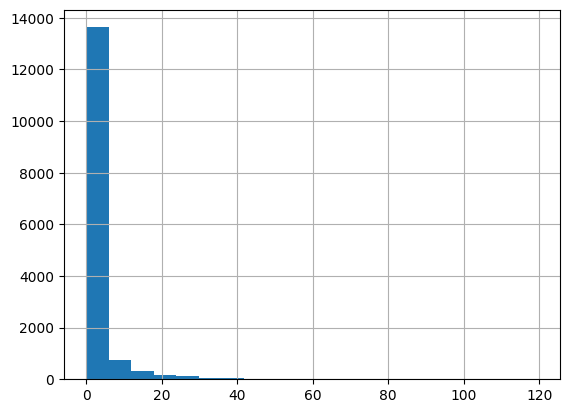

In [8]:
ciudades_df['Rainfall'].hist(bins=20)

In [9]:
for ciudad in ciudades:
    rain = \
        ciudades_df[ciudades_df['Location'] == ciudad]['Rainfall'].mode()[0]
    print(f'{ciudad + ":":17} {rain}')

Sydney:           0.0
SydneyAirport:    0.0
Canberra:         0.0
Melbourne:        0.0
MelbourneAirport: 0.0


In [10]:
ciudades_df['Rainfall'].fillna(0.0, inplace=True)

## Evaporation

En esta variable vemos que la distribución es bastante simétrica, además la media y la mediana tiene valores muy cercanos, en esta caso no hay sesgo, por lo tanto decidimos completar los valores faltante con la media.

<Axes: >

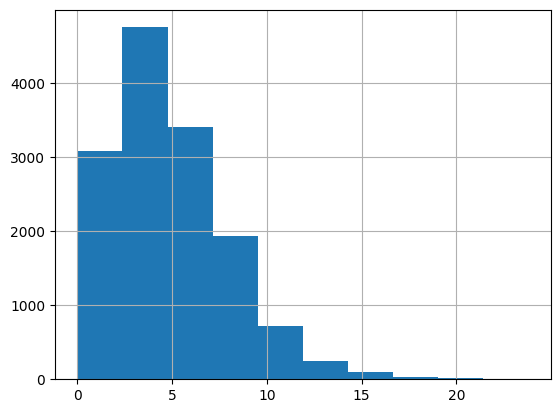

In [11]:
ciudades_df['Evaporation'].hist()

In [12]:
ciudades_df['Evaporation'].mean(), ciudades_df['Evaporation'].median()

(4.866827731092437, 4.2)

In [13]:
ciudades_df['Evaporation']\
    .fillna(
        ciudades_df['Evaporation'].mean(),
        inplace=True)

## Sunshine

En este histograma vemos que la distribución es bimodal, por lo que para imputar los valores faltantes vamos usar la mediana, ya que la media está sesgada por la gran cantidad de `0.0`

<Axes: >

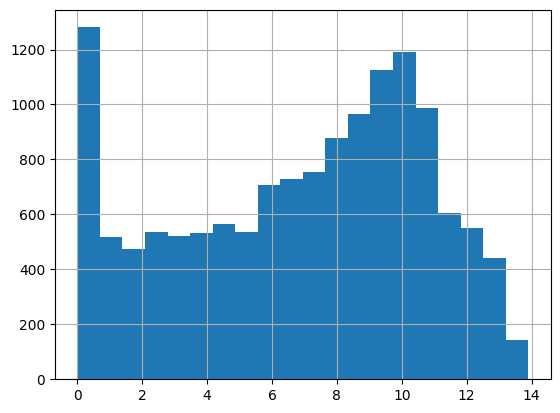

In [14]:
ciudades_df['Sunshine'].hist(bins=20)

In [15]:
ciudades_df['Sunshine']\
    .fillna(
        ciudades_df['Sunshine'].median(),
        inplace=True)

## WindGustDir 🟡

Como esta variable tiene años faltantes y teniendo las variables `WindDir9am` y `WindDir3pm` decidimos eliminarla del dataframe.

In [16]:
ciudades_df.drop(labels='WindGustDir', axis=1, inplace=True)

## WindGustSpeed 🟡

In [17]:
ciudades_df['WindGustSpeed']\
    .fillna(
        ciudades_df['WindGustSpeed'].median(),
        inplace=True)

## WindDir 🟡

In [18]:
ciudades_df['WindDir9am'].fillna(method='ffill', inplace=True)
ciudades_df['WindDir3pm'].fillna(method='ffill', inplace=True)

C:\Users\edus_\AppData\Local\Temp\ipykernel_10172\3962893931.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ciudades_df['WindDir9am'].fillna(method='ffill', inplace=True)
C:\Users\edus_\AppData\Local\Temp\ipykernel_10172\3962893931.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ciudades_df['WindDir3pm'].fillna(method='ffill', inplace=True)


## WindSpeed

En este caso observando la mediana, media e histogramas vemos que podemos completar los valores faltantes con la media.

<Axes: >

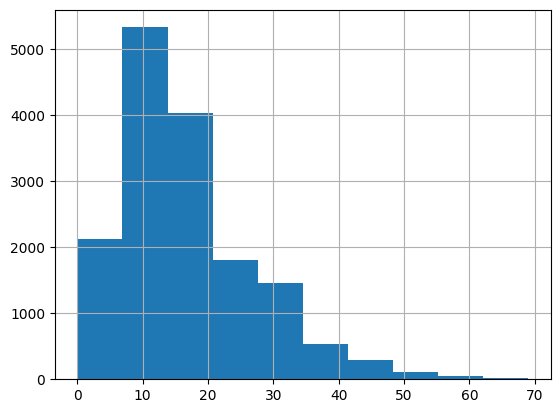

In [19]:
ciudades_df['WindSpeed9am'].hist()

In [20]:
ciudades_df['WindSpeed9am'].mean(), ciudades_df['WindSpeed9am'].median()

(16.613672496025437, 15.0)

In [21]:
ciudades_df['WindSpeed9am']\
    .fillna(
        ciudades_df['WindSpeed9am'].mean(),
        inplace=True)

<Axes: >

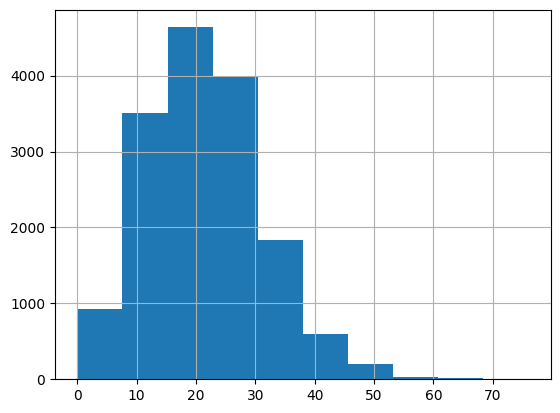

In [22]:
ciudades_df['WindSpeed3pm'].hist()

In [23]:
ciudades_df['WindSpeed3pm'].mean(), ciudades_df['WindSpeed3pm'].median()

(21.797165914723262, 20.0)

In [24]:
ciudades_df['WindSpeed3pm']\
    .fillna(
        ciudades_df['WindSpeed3pm'].mean(),
        inplace=True)

## Humidity

<Axes: >

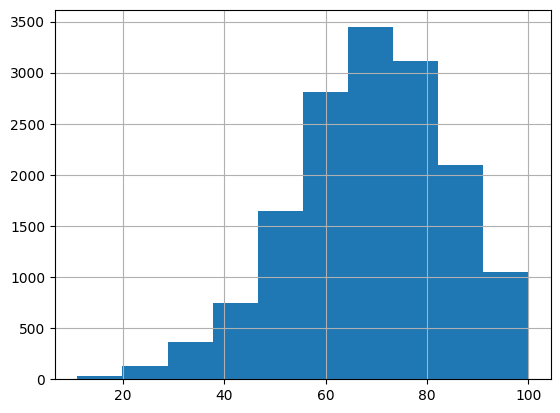

In [25]:
ciudades_df['Humidity9am'].hist()

In [26]:
ciudades_df['Humidity9am'].mean(), ciudades_df['Humidity9am'].median()

(68.90302283341983, 70.0)

In [27]:
ciudades_df['Humidity9am']\
    .fillna(
        ciudades_df['Humidity9am'].mean(),
        inplace=True)

<Axes: >

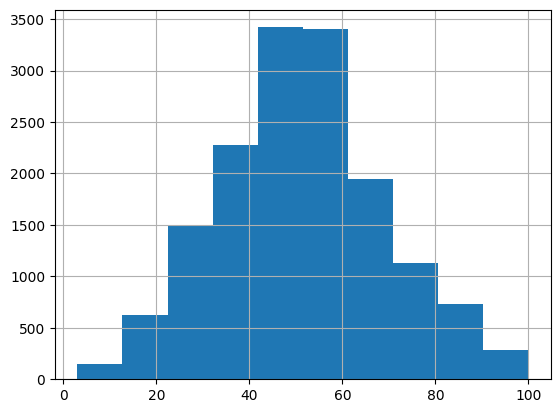

In [28]:
ciudades_df['Humidity3pm'].hist()

In [29]:
ciudades_df['Humidity3pm'].mean(), ciudades_df['Humidity3pm'].median()

(51.280576935515164, 51.0)

In [30]:
ciudades_df['Humidity3pm']\
    .fillna(
        ciudades_df['Humidity3pm'].mean(),
        inplace=True)

## Pressure

<Axes: >

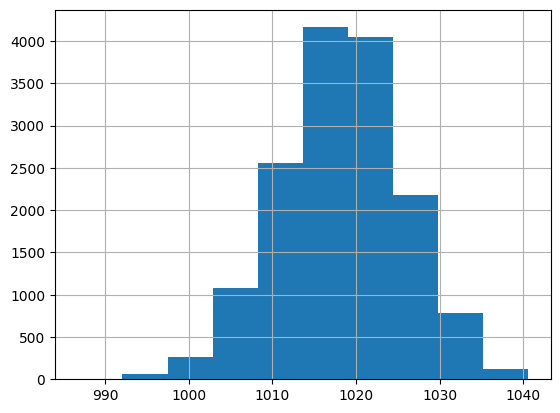

In [31]:
ciudades_df['Pressure9am'].hist()

In [32]:
ciudades_df['Pressure9am'].mean(), ciudades_df['Pressure9am'].median() 

(1018.305835682906, 1018.5)

In [33]:
ciudades_df['Pressure9am']\
    .fillna(
        ciudades_df['Pressure9am'].mean(),
        inplace=True)

<Axes: >

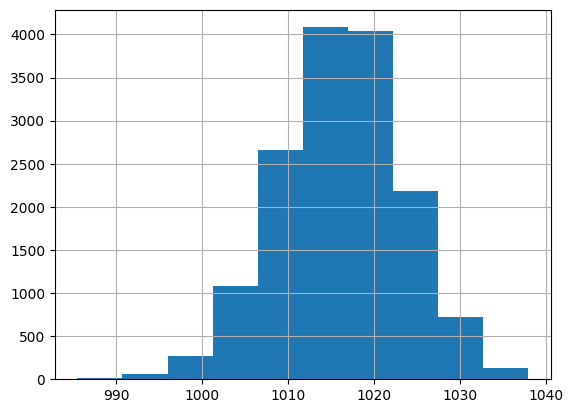

In [34]:
ciudades_df['Pressure3pm'].hist()

In [35]:
ciudades_df['Pressure3pm'].mean(), ciudades_df['Pressure3pm'].median() 

(1016.0642393184796, 1016.3)

In [36]:
ciudades_df['Pressure3pm']\
    .fillna(
        ciudades_df['Pressure3pm'].mean(),
        inplace=True)

## Cloud

En el caso de estas variables vemos que parece tratarse de una distribución bimodal y que los valores entres las ciudades son muy parecidos, por lo tanto vamos a completar estos datos faltantes con la mediana de todas las ciudades.

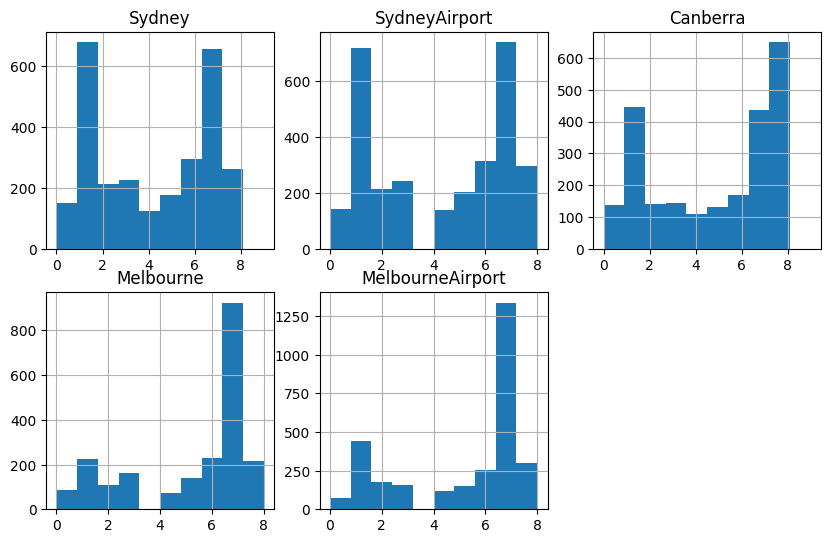

In [37]:
plt.figure(figsize=(10, 6.2))

var = 'Cloud9am'

for idx, ciudad in enumerate(ciudades):
    plt.subplot(2, 3, idx + 1)
    ciudades_df[ciudades_df['Location'] == ciudad][var].hist()
    plt.title(ciudad)

In [38]:
ciudades_df['Cloud9am'].describe()

count    13309.000000
mean         4.750545
std          2.728329
min          0.000000
25%          2.000000
50%          6.000000
75%          7.000000
max          9.000000
Name: Cloud9am, dtype: float64

In [39]:
ciudades_df['Cloud9am']\
    .fillna(
        ciudades_df['Cloud9am'].median(),
        inplace=True)

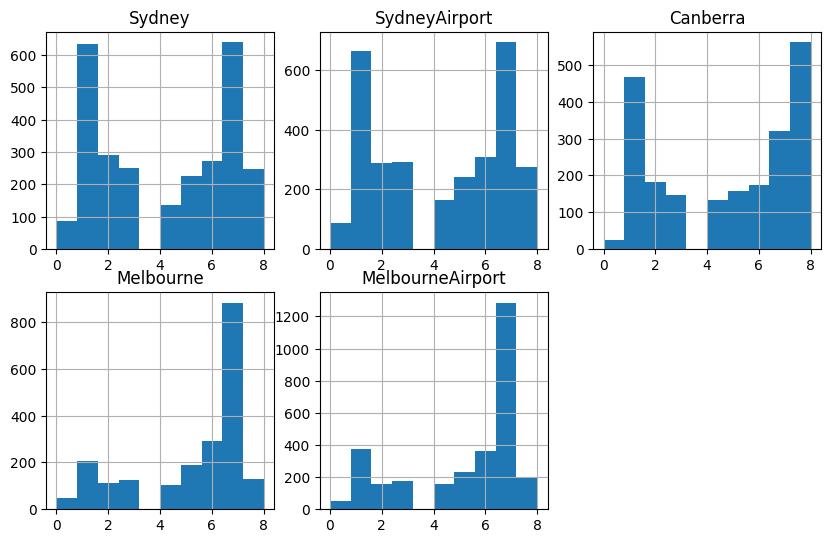

In [40]:
plt.figure(figsize=(10, 6.2))

var = 'Cloud3pm'

for idx, ciudad in enumerate(ciudades):
    plt.subplot(2, 3, idx + 1)
    ciudades_df[ciudades_df['Location'] == ciudad][var].hist()
    plt.title(ciudad)

In [41]:
ciudades_df['Cloud3pm'].describe()

count    13054.000000
mean         4.746131
std          2.589879
min          0.000000
25%          2.000000
50%          6.000000
75%          7.000000
max          8.000000
Name: Cloud3pm, dtype: float64

In [42]:
ciudades_df['Cloud3pm']\
    .fillna(
        ciudades_df['Cloud3pm'].median(),
        inplace=True)

## Temp

<Axes: >

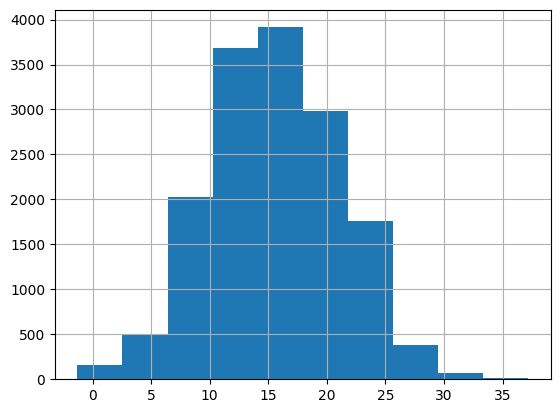

In [43]:
ciudades_df['Temp9am'].hist()

In [44]:
ciudades_df['Temp9am'].mean(), ciudades_df['Temp9am'].median()  

(15.545953103804665, 15.4)

In [45]:
ciudades_df['Temp9am']\
    .fillna(
        ciudades_df['Temp9am'].mean(),
        inplace=True)

<Axes: >

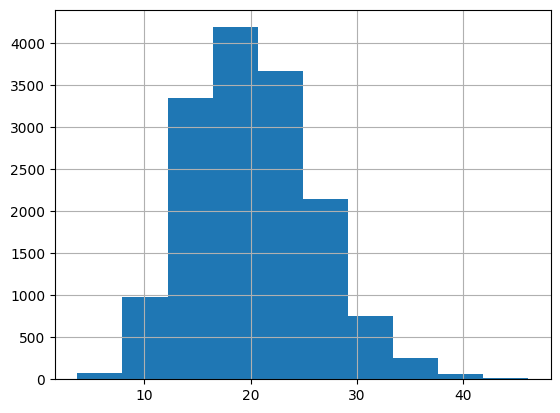

In [46]:
ciudades_df['Temp3pm'].hist()

In [47]:
ciudades_df['Temp3pm'].mean(), ciudades_df['Temp3pm'].median()  

(20.22915429309232, 19.8)

In [48]:
ciudades_df['Temp3pm']\
    .fillna(
        ciudades_df['Temp3pm'].mean(),
        inplace=True)

## RainToday y RainTomorrow

In [49]:
ciudades_df['RainToday'].fillna(method='ffill', inplace=True)
ciudades_df['RainTomorrow'].fillna(method='ffill', inplace=True)

C:\Users\edus_\AppData\Local\Temp\ipykernel_10172\2858844759.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ciudades_df['RainToday'].fillna(method='ffill', inplace=True)
C:\Users\edus_\AppData\Local\Temp\ipykernel_10172\2858844759.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ciudades_df['RainTomorrow'].fillna(method='ffill', inplace=True)


## RainfallTomorrow

In [50]:
ciudades_df['RainfallTomorrow'].fillna(0.0, inplace=True)

# Normalización 

In [51]:
ciudades_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15986 entries, 0 to 15985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Location          15986 non-null  object 
 1   MinTemp           15986 non-null  float64
 2   MaxTemp           15986 non-null  float64
 3   Rainfall          15986 non-null  float64
 4   Evaporation       15986 non-null  float64
 5   Sunshine          15986 non-null  float64
 6   WindGustSpeed     15986 non-null  float64
 7   WindDir9am        15986 non-null  object 
 8   WindDir3pm        15986 non-null  object 
 9   WindSpeed9am      15986 non-null  float64
 10  WindSpeed3pm      15986 non-null  float64
 11  Humidity9am       15986 non-null  float64
 12  Humidity3pm       15986 non-null  float64
 13  Pressure9am       15986 non-null  float64
 14  Pressure3pm       15986 non-null  float64
 15  Cloud9am          15986 non-null  float64
 16  Cloud3pm          15986 non-null  float6

In [52]:
ciudades_df = pd.get_dummies(
                    ciudades_df,
                    columns=[
                        'RainToday',
                        'RainTomorrow'],
                    drop_first=True)

In [53]:
ciudades_df.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
       'RainfallTomorrow', 'RainToday_Yes', 'RainTomorrow_Yes'],
      dtype='object')

In [54]:
ciudades_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15986 entries, 0 to 15985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Location          15986 non-null  object 
 1   MinTemp           15986 non-null  float64
 2   MaxTemp           15986 non-null  float64
 3   Rainfall          15986 non-null  float64
 4   Evaporation       15986 non-null  float64
 5   Sunshine          15986 non-null  float64
 6   WindGustSpeed     15986 non-null  float64
 7   WindDir9am        15986 non-null  object 
 8   WindDir3pm        15986 non-null  object 
 9   WindSpeed9am      15986 non-null  float64
 10  WindSpeed3pm      15986 non-null  float64
 11  Humidity9am       15986 non-null  float64
 12  Humidity3pm       15986 non-null  float64
 13  Pressure9am       15986 non-null  float64
 14  Pressure3pm       15986 non-null  float64
 15  Cloud9am          15986 non-null  float64
 16  Cloud3pm          15986 non-null  float6

In [55]:
categoricas = ['Location', 'WindDir9am', 'WindDir3pm',
               'RainToday_Yes', 'RainTomorrow_Yes']

In [56]:
numeric_df = ciudades_df.drop(labels=categoricas, axis=1).copy()

In [57]:
numeric_df

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
0,19.5,22.4,15.6,6.200000,0.0,43.0,17.0,20.0,92.0,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,6.0
1,19.5,25.6,6.0,3.400000,2.7,43.0,9.0,13.0,83.0,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,6.6
2,21.6,24.5,6.6,2.400000,0.1,43.0,17.0,2.0,88.0,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,18.8
3,20.2,22.8,18.8,2.200000,0.0,43.0,22.0,20.0,83.0,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,77.4
4,19.7,25.7,77.4,4.866828,0.0,43.0,11.0,6.0,88.0,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15981,6.4,15.8,0.0,2.400000,8.8,39.0,11.0,17.0,84.0,56.0,1028.1,1024.5,1.0,7.0,7.9,15.6,0.6
15982,7.8,13.5,0.6,0.600000,0.0,24.0,2.0,9.0,100.0,80.0,1028.8,1028.4,7.0,7.0,11.2,12.7,0.2
15983,6.7,14.1,0.2,0.600000,0.0,24.0,9.0,11.0,93.0,56.0,1028.2,1024.8,7.0,7.0,7.5,13.5,0.0
15984,7.4,14.9,0.0,1.600000,6.0,44.0,17.0,19.0,77.0,63.0,1018.8,1013.8,1.0,7.0,9.1,12.5,1.4


In [58]:
df_norm = (numeric_df - numeric_df.mean()) / numeric_df.std()

In [59]:
df_norm = pd.concat([df_norm, ciudades_df[['RainToday_Yes', 'RainTomorrow_Yes']]], axis=1)

# Matriz de correlación

<Axes: >

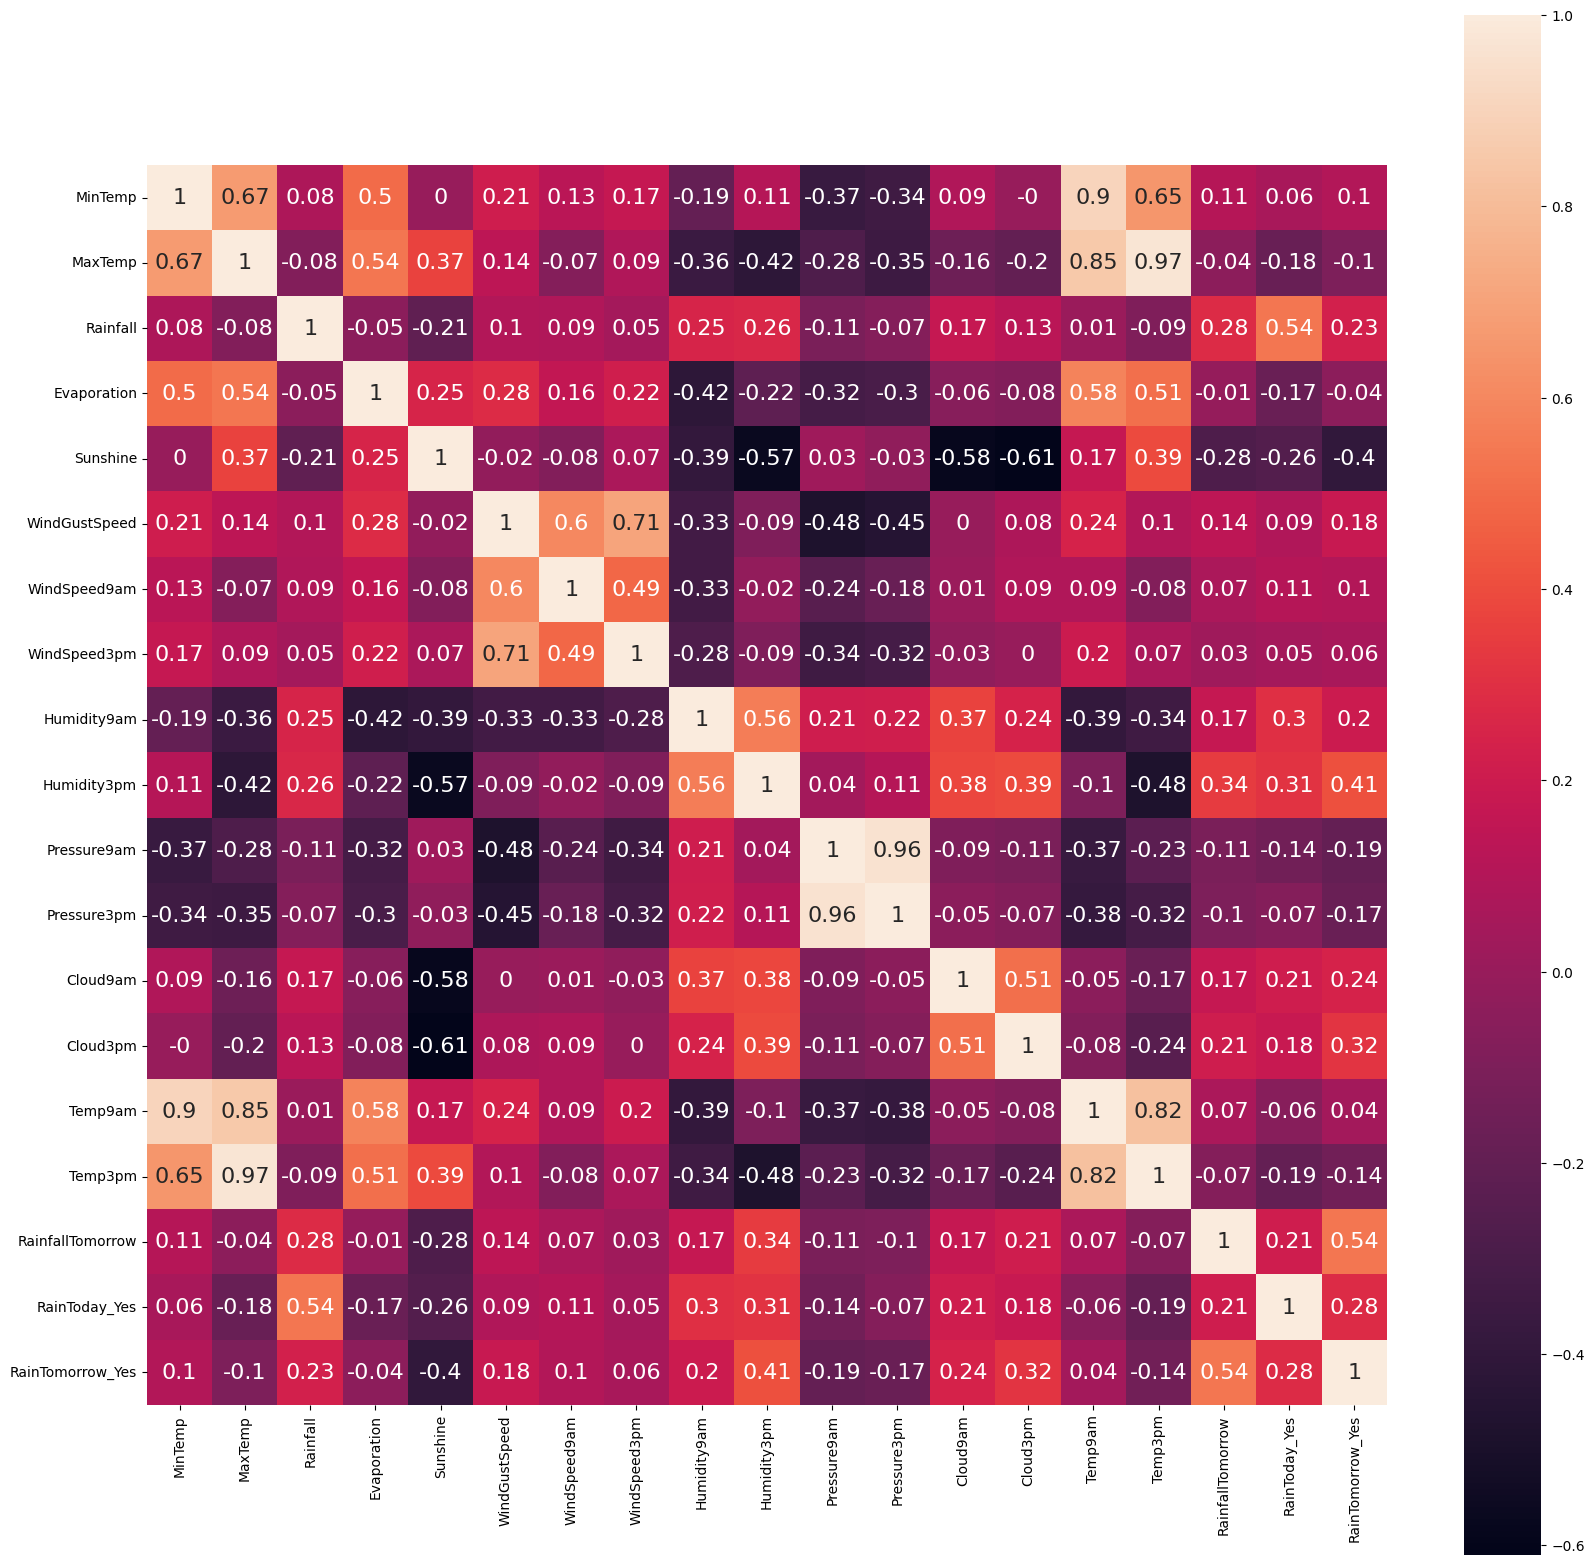

In [60]:
plt.figure(figsize=(20, 20))

sns.heatmap(
    df_norm.corr().round(2),
    annot=True,
    square=True,
    annot_kws={'size': 16}
)

# Scatter plot entre `RainfallTomorrow` y el resto de variables

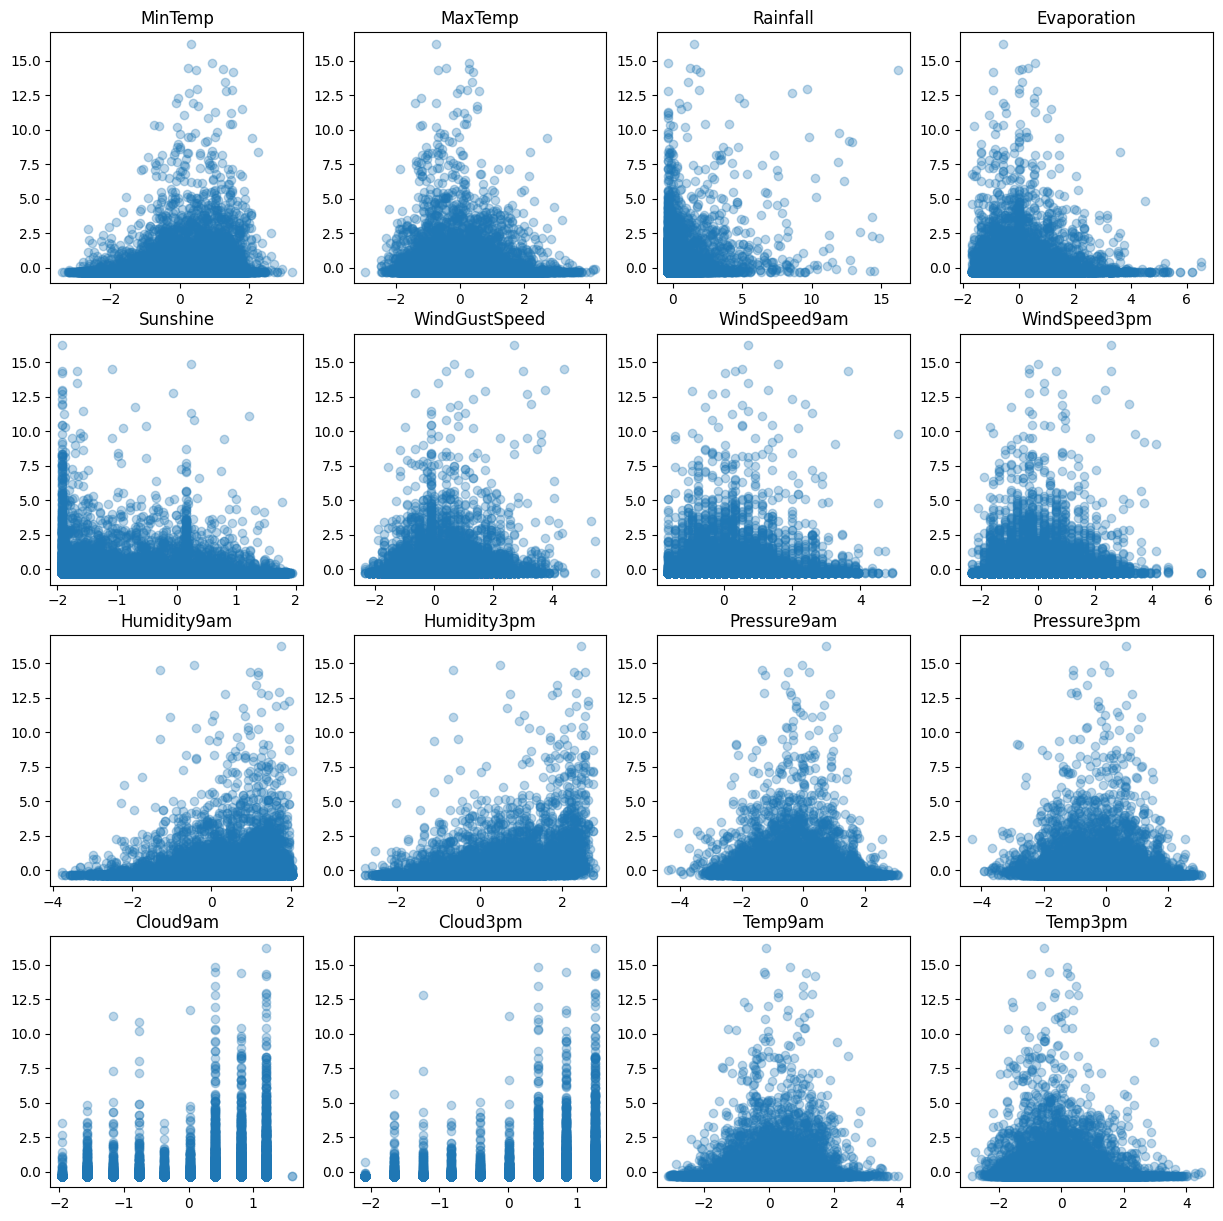

In [61]:
plt.figure(figsize=(15, 15))

for idx, col in enumerate(df_norm.columns[:-3], start=1):
    plt.subplot(4, 4, idx)
    plt.scatter(data=df_norm, x=col, y='RainfallTomorrow', alpha=.3)
    plt.title(col)

# ¿Está balanceado el dataset?

El dataset no está balanceado porque la variable independietne que queremos predecir tiene muchos valores iguales a $0$.

# Regresión lineal

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

In [63]:
def metricas(y_test, y_pred):
    print("R2:   %.2f" % r2_score(y_test, y_pred))
    print("MSE:  %.2f" % mean_squared_error(y_test, y_pred))
    print("RMSE: %.2f" % sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE:  %.2f" % mean_absolute_error(y_test, y_pred))
    print("MAPE: %.2f" % mean_absolute_percentage_error(y_test, y_pred))

In [64]:
x_train, x_test, y_train, y_test = \
    train_test_split(df_norm[['Rainfall', 'Sunshine', 'Humidity3pm', 'MinTemp',
                              'MaxTemp', 'WindGustSpeed', 'RainToday_Yes', 
                              'RainTomorrow_Yes']],
                     df_norm['RainfallTomorrow'],
                     test_size=0.2,
                     random_state=1)

In [65]:
regr = LinearRegression()
regr.fit(x_train, y_train)

LinearRegression()

In [66]:
y_pred = regr.predict(x_test)

In [67]:
metricas(y_test, y_pred)

R2:   0.35
MSE:  0.65
RMSE: 0.81
MAE:  0.34
MAPE: 5.38


# Gradiente descendiente

In [68]:
from sklearn.linear_model import SGDRegressor

In [69]:
grad = SGDRegressor(max_iter=1000)
grad.fit(x_train, y_train)

SGDRegressor()

In [70]:
y_pred = grad.predict(x_test)

In [71]:
metricas(y_test, y_pred)

R2:   0.33
MSE:  0.67
RMSE: 0.82
MAE:  0.36
MAPE: 5.68


# Regularización

## Ridge

In [72]:
from sklearn.linear_model import RidgeCV

In [73]:
rid = RidgeCV(alphas=np.logspace(-10, 10, 200))
rid.fit(x_train, y_train)

RidgeCV(alphas=array([1.00000000e-10, 1.26038293e-10, 1.58856513e-10, 2.00220037e-10,
       2.52353917e-10, 3.18062569e-10, 4.00880633e-10, 5.05263107e-10,
       6.36824994e-10, 8.02643352e-10, 1.01163798e-09, 1.27505124e-09,
       1.60705282e-09, 2.02550194e-09, 2.55290807e-09, 3.21764175e-09,
       4.05546074e-09, 5.11143348e-09, 6.44236351e-09, 8.11984499e-09,
       1.02341140e-08, 1.28989026e-0...
       4.88025158e+07, 6.15098579e+07, 7.75259749e+07, 9.77124154e+07,
       1.23155060e+08, 1.55222536e+08, 1.95639834e+08, 2.46581108e+08,
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10]))

In [74]:
y_pred = rid.predict(x_test)

In [75]:
metricas(y_test, y_pred)

R2:   0.35
MSE:  0.65
RMSE: 0.81
MAE:  0.34
MAPE: 5.37


## Lasso

In [76]:
from sklearn.linear_model import LassoCV

In [77]:
las = LassoCV(alphas=np.logspace(-10, 10, 200), cv=10)
las.fit(x_train, y_train)

LassoCV(alphas=array([1.00000000e-10, 1.26038293e-10, 1.58856513e-10, 2.00220037e-10,
       2.52353917e-10, 3.18062569e-10, 4.00880633e-10, 5.05263107e-10,
       6.36824994e-10, 8.02643352e-10, 1.01163798e-09, 1.27505124e-09,
       1.60705282e-09, 2.02550194e-09, 2.55290807e-09, 3.21764175e-09,
       4.05546074e-09, 5.11143348e-09, 6.44236351e-09, 8.11984499e-09,
       1.02341140e-08, 1.28989026e-0...
       4.88025158e+07, 6.15098579e+07, 7.75259749e+07, 9.77124154e+07,
       1.23155060e+08, 1.55222536e+08, 1.95639834e+08, 2.46581108e+08,
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10]),
        cv=10)

In [78]:
y_pred = las.predict(x_test)

In [79]:
metricas(y_test, y_pred)

R2:   0.35
MSE:  0.65
RMSE: 0.81
MAE:  0.34
MAPE: 5.38


## ElasticNet

In [80]:
from sklearn.linear_model import ElasticNetCV

In [81]:
en = ElasticNetCV(alphas=np.logspace(-10, 10, 200))
en.fit(x_train, y_train)

ElasticNetCV(alphas=array([1.00000000e-10, 1.26038293e-10, 1.58856513e-10, 2.00220037e-10,
       2.52353917e-10, 3.18062569e-10, 4.00880633e-10, 5.05263107e-10,
       6.36824994e-10, 8.02643352e-10, 1.01163798e-09, 1.27505124e-09,
       1.60705282e-09, 2.02550194e-09, 2.55290807e-09, 3.21764175e-09,
       4.05546074e-09, 5.11143348e-09, 6.44236351e-09, 8.11984499e-09,
       1.02341140e-08, 1.289890...
       4.88025158e+07, 6.15098579e+07, 7.75259749e+07, 9.77124154e+07,
       1.23155060e+08, 1.55222536e+08, 1.95639834e+08, 2.46581108e+08,
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10]))

In [82]:
y_pred = en.predict(x_test)

In [83]:
metricas(y_test, y_pred)

R2:   0.35
MSE:  0.65
RMSE: 0.81
MAE:  0.34
MAPE: 5.38


###Modelo Base###

In [84]:

X = df_norm[['MaxTemp', 'Evaporation', 'Sunshine']]
Y = df_norm['RainfallTomorrow']

# Dividir los datos en conjunto de entrenamiento y de prueba
X_train_Base, X_test_Base, Y_train_Base, Y_test_Base = train_test_split(X, Y, test_size=0.20, random_state= 1)

In [85]:
M_base = LinearRegression()

In [86]:
M_base.fit(X_train_Base, Y_train_Base)

LinearRegression()

In [89]:
y_pred = M_base.predict(X_test_Base)

In [90]:
metricas(Y_test_Base, y_pred)

R2:   0.09
MSE:  0.91
RMSE: 0.95
MAE:  0.43
MAPE: 2.23
